In [ ]:
#!git clone https://github.com/whyhardt/SPICE.git

In [ ]:
# !pip install -e SPICE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from spice import SpiceEstimator, SpiceConfig, convert_dataset, BaseRNN, plot_session

# For custom RNN
import torch
import torch.nn as nn

## Load dataset

Let's load the data first with the `convert_dataset` method. This method returns a `SpiceDataset` object which we can use right away 

In [2]:
# Load your data
file = '../data/bustamante2023/bustamante2023_processed.csv'
dataset = convert_dataset(
    file = file,
    df_participant_id='subject_id',
    df_choice='decision',
    df_reward='reward',
    df_block='overall_round',
    additional_inputs=['harvest_duration', 'travel_duration'],
    timeshift_additional_inputs=False,
    )

# structure of dataset:
# dataset has two main attributes: xs -> inputs; ys -> targets (next action)
# shape: (n_participants*n_blocks*n_experiments, n_timesteps, features)
# features are (n_actions * action, n_actions * reward, n_additional_inputs * additional_input, block_number, experiment_id, participant_id)

# in order to set up the participant embedding we have to compute the number of unique participants in our data 
# to get the number of participants n_participants we do:
n_participants = len(dataset.xs[..., -1].unique())

print(f"Shape of dataset: {dataset.xs.shape}")
print(f"Number of participants: {n_participants}")
n_actions = dataset.ys.shape[-1]
print(f"Number of actions in dataset: {n_actions}")
print(f"Number of additional inputs: {dataset.xs.shape[-1]-2*n_actions-3}")

Shape of dataset: torch.Size([1997, 112, 9])
Number of participants: 250
Number of actions in dataset: 2
Number of additional inputs: 2


In [3]:
# inspect dataset
dataset.xs[0, :10, :]

tensor([[1.0000, 0.0000, 0.7561,    nan, 2.0000, 8.3333, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.6859,    nan, 2.0000, 8.3333, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000,    nan, 0.0510, 2.0000, 8.3333, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.7515,    nan, 2.0000, 8.3333, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.6407,    nan, 2.0000, 8.3333, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.5662,    nan, 2.0000, 8.3333, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000,    nan, 0.0510, 2.0000, 8.3333, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.8706,    nan, 2.0000, 8.3333, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.7226,    nan, 2.0000, 8.3333, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000,    nan, 0.0510, 2.0000, 8.3333, 0.0000, 0.0000, 0.0000]])

## SPICE Setup

Now we are going to define the configuration for SPICE with a `SpiceConfig` object.

The `SpiceConfig` takes as arguments 
1. `library_setup (dict)`: Defining the variable names of each module.
2. `memory_state (dict)`: Defining the memory state variables and their initial values.
3. `states_in_logit (list)`: Defining which of the memory state variables are used later for the logit computation. This is necessary for some background processes.  

In [4]:
spice_config = SpiceConfig(
    library_setup={
        'value_stay': ['reward', 'harvest_duration'],
        'value_exit': ['travel_duration'],
    },
    
    memory_state={
            'value': 0.,
        }
)

And now we are going to define the SPICE model which is a child of the `BaseRNN` and `torch.nn.Module` class and takes as required arguments:
1. `spice_config (SpiceConfig)`: previously defined SpiceConfig object
2. `n_actions (int)`: number of possible actions in your dataset (including non-displayed ones if applicable).
3. `n_participants (int)`: number of participants in your dataset.

As usual for a `torch.nn.Module` we have to define at least the `__init__` method and the `forward` method.
The `forward` method gets called when computing a forward pass through the model and takes as inputs `(inputs (SpiceDataset.xs), prev_state (dict, default: None), batch_first (bool, default: False))` and returns `(logits (torch.Tensor, shape: (n_participants*n_blocks*n_experiments, timesteps, n_actions)), updated_state (dict))`. Two necessary method calls inside the forward pass are:
1. `self.init_forward_pass(inputs, prev_state, batch_first) -> SpiceSignals`: returns a `SpiceSignals` object which carries all relevant information already processed.
2. `self.post_forward_pass(SpiceSignals, batch_first) -> SpiceSignals`: does some re-arranging of the logits to adhere to `batch_first`.

In [5]:
class SPICERNN(BaseRNN):
    
    def __init__(self, spice_config, **kwargs):
        super().__init__(spice_config=spice_config, **kwargs)
        
        # participant embedding
        self.participant_embedding = self.setup_embedding(num_embeddings=n_participants, embedding_size=self.embedding_size, dropout=0.)
        
        # set up the submodules
        self.setup_module(key_module='value_stay', input_size=2+self.embedding_size)
        self.setup_module(key_module='value_exit', input_size=1+self.embedding_size)
        
    def forward(self, inputs, prev_state, batch_first=False):
        
        spice_signals = self.init_forward_pass(inputs, prev_state, batch_first)
        
        harvest_duration = spice_signals.additional_inputs[..., 0].unsqueeze(-1).repeat(1, 1, self.n_actions)
        travel_duration = spice_signals.additional_inputs[..., 1].unsqueeze(-1).repeat(1, 1, self.n_actions)
        rewards_chosen = (spice_signals.actions * spice_signals.rewards).sum(dim=-1, keepdim=True).repeat(1, 1, self.n_actions)
        
        # time-invariant participant features
        participant_embeddings = self.participant_embedding(spice_signals.participant_ids)
        mask_stay = torch.tensor((1,0)).reshape(1, self.n_actions).repeat(rewards_chosen.shape[1], 1)
        mask_exit = torch.tensor((0,1)).reshape(1, self.n_actions).repeat(rewards_chosen.shape[1], 1)
        
        for timestep in spice_signals.timesteps:
            
            # update chosen value
            self.call_module(
                key_module='value_stay',
                key_state='value',
                action_mask=mask_stay,
                inputs=(
                    rewards_chosen[timestep], 
                    harvest_duration[timestep], 
                    ),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )
            
            # update not chosen value
            self.call_module(
                key_module='value_exit',
                key_state='value',
                action_mask=mask_exit,
                inputs=(
                    travel_duration[timestep], 
                    ),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )
            
            # transform logits from item-space to action-space
            spice_signals.logits[timestep] = self.state['value']
            
        spice_signals = self.post_forward_pass(spice_signals, batch_first)
        
        return spice_signals.logits, self.get_state()

Let's setup now the `SpiceEstimator` object and fit it to the data!

In [6]:
path_spice = '../params/bustamante2023/spice_bustamante2023.pkl'
estimator = SpiceEstimator(
        # model paramaeters
        rnn_class=SPICERNN,
        spice_config=spice_config,
        n_actions=2,
        n_participants=n_participants,
        n_experiments=1,
        
        # rnn training parameters
        epochs=1000,
        warmup_steps=200,
        learning_rate=0.01,
        
        # sindy fitting parameters
        sindy_weight=0.1,
        sindy_threshold=0.05,
        sindy_threshold_frequency=1,
        sindy_threshold_terms=1,
        sindy_cutoff_patience=100,
        sindy_epochs=1000,
        sindy_alpha=0.0001,
        sindy_library_polynomial_degree=2,
        sindy_ensemble_size=1,
        
        # additional generalization parameters
        batch_size=1024,
        bagging=True,
        scheduler=True,
        
        verbose=True,
        save_path_spice=path_spice,
    )

In [ ]:
print(f"\nStarting training on {estimator.device}...")
print("=" * 80)
estimator.fit(dataset.xs, dataset.ys, dataset.xs, dataset.ys)
# estimator.load_spice(args.model)
print("=" * 80)
print("\nTraining complete!")

# Print example SPICE model for first participant
print("\nExample SPICE model (participant 0):")
print("-" * 80)
estimator.print_spice_model(participant_id=0)
print("-" * 80)


Starting training on cpu...

Training the RNN...
Epoch 1/1000 --- L(Train): 0.5092973 --- L(Val, RNN): 0.3817756 --- L(Val, SINDy): 3.8043301 --- Time: 1.18s; --- Convergence: 8.09e-01; LR: 1.00e-02; Metric: inf; Bad epochs: 0/100
--------------------------------------------------------------------------------
SPICE Model (Coefficients: 16):
value_stay[t+1] = 0.002 1 + 1.001 value_stay[t] + 0.002 reward + -0.0 harvest_duration + -0.0 value_stay^2 + 0.001 value_stay*reward + -0.001 value_stay*harvest_duration + 0.002 reward^2 + 0.004 reward*harvest_duration + -0.001 harvest_duration^2 
value_exit[t+1] = 0.011 1 + 1.011 value_exit[t] + -0.01 travel_duration + 0.01 value_exit^2 + -0.009 value_exit*travel_duration + -0.009 travel_duration^2 
--------------------------------------------------------------------------------
Cutoff patience:
value_stay: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
value_exit: 0, 0, 0, 0, 0, 0
Epoch 2/1000 --- L(Train): 0.3793685 --- L(Val, RNN): 0.3679760 --- L(Val, SINDy): 

In [7]:
estimator.load_spice(path_spice)

In [9]:
df = pd.read_csv(file)
df['last_reward'] = df.groupby('subject_id')['last_reward'].fillna(method='bfill')
df['participant_id'] = pd.factorize(df['subject_id'])[0]
exit_df = df[df['decision'] == 1]
mean_exit_threshold = exit_df.groupby(['participant_id', 'subject_id'])['last_reward'].mean().reset_index()
mean_exit_threshold['relative_optimal'] = mean_exit_threshold['last_reward'] - 6.78 #from Bustamante et al. Table S7, experiment 1
mean_exit_threshold['over_harvester'] = np.where(mean_exit_threshold['relative_optimal'] <= 0, 1, 0)
print(mean_exit_threshold)
overharvesters = mean_exit_threshold[mean_exit_threshold['over_harvester'] == 1]['participant_id'].unique()
underharvesters = mean_exit_threshold[mean_exit_threshold['over_harvester'] == 0]['participant_id'].unique()

     participant_id                subject_id  last_reward  relative_optimal  \
0                 0  08aiu2bm6t15qij5826jxz50     8.241283          1.461283   
1                 1  09j932f828pn7h7bozp9mpnl     5.344722         -1.435278   
2                 2  0ax9htcbhfi3ncsospqzwjx2     8.945571          2.165571   
3                 3  0e6zivqly335lojgb4c6606t     7.554696          0.774696   
4                 4  0fawro1pivqnh4lem4ayf4o0     3.089682         -3.690318   
..              ...                       ...          ...               ...   
245             245  fzllq0yp08zefacpmy7dqq0u     9.041866          2.261866   
246             246  g2n23l2w8uf3brbllm4sbrcx     8.106489          1.326489   
247             247  g9wqksieqbldodjoyuci048q     6.765186         -0.014814   
248             248  garkh3hmuozi9loxpee54z20     7.720383          0.940383   
249             249  gd6af6pqeo2d0x2dcumwirmy     3.908357         -2.871643   

     over_harvester  
0                

In [10]:
print('OVERHARVESTERS') 
for p in overharvesters:
    print('Participant number', p)
    estimator.print_spice_model(participant_id=p)

OVERHARVESTERS
Participant number 1
value_stay[t+1] = 0.773 value_stay[t] + 0.5 reward + 0.061 harvest_duration + -0.229 value_stay*harvest_duration + 0.496 reward*harvest_duration 
value_exit[t+1] = 1.0 value_exit[t] 
Participant number 4
value_stay[t+1] = 0.164 1 + 0.724 value_stay[t] + 0.249 reward + 0.168 harvest_duration + -0.277 value_stay*harvest_duration + 0.248 reward*harvest_duration + 0.165 harvest_duration^2 
value_exit[t+1] = 1.0 value_exit[t] 
Participant number 7
value_stay[t+1] = 0.085 1 + 0.712 value_stay[t] + 0.455 reward + 0.085 harvest_duration + -0.287 value_stay*harvest_duration + 0.455 reward*harvest_duration + 0.085 harvest_duration^2 
value_exit[t+1] = 1.0 value_exit[t] 
Participant number 12
value_stay[t+1] = 0.095 1 + 0.717 value_stay[t] + 0.435 reward + 0.096 harvest_duration + -0.282 value_stay*harvest_duration + 0.434 reward*harvest_duration + 0.093 harvest_duration^2 
value_exit[t+1] = 1.0 value_exit[t] 
Participant number 13
value_stay[t+1] = 0.096 1 + 0

In [11]:
print('UNDERHARVESTERS') 
for p in underharvesters:
    print('Participant number', p)
    estimator.print_spice_model(participant_id=p)

UNDERHARVESTERS
Participant number 0
value_stay[t+1] = 0.668 value_stay[t] + 0.476 reward + 0.055 harvest_duration + -0.334 value_stay*harvest_duration + 0.477 reward*harvest_duration + 0.055 harvest_duration^2 
value_exit[t+1] = 1.0 value_exit[t] 
Participant number 2
value_stay[t+1] = 0.82 value_stay[t] + 0.208 reward + -0.179 value_stay*harvest_duration + 0.11 reward^2 + 0.207 reward*harvest_duration 
value_exit[t+1] = 1.0 value_exit[t] 
Participant number 3
value_stay[t+1] = 0.097 1 + 0.681 value_stay[t] + 0.488 reward + 0.097 harvest_duration + -0.317 value_stay*harvest_duration + 0.485 reward*harvest_duration 
value_exit[t+1] = 1.0 value_exit[t] 
Participant number 5
value_stay[t+1] = 0.057 1 + 0.665 value_stay[t] + 0.481 reward + 0.057 harvest_duration + -0.331 value_stay*harvest_duration + 0.479 reward*harvest_duration + 0.058 harvest_duration^2 
value_exit[t+1] = 1.0 value_exit[t] 
Participant number 6
value_stay[t+1] = 0.055 1 + 0.667 value_stay[t] + 0.397 reward + 0.056 harv

## Benchmarking

### MVT Model by Constantino et al. (2015)

In [8]:
import sys

sys.path.append("../..")
from weinhardt2025.benchmarking.benchmarking_bustamante2023 import MarginalValueTheoremModel
from weinhardt2025.benchmarking.benchmarking_gru import training
from spice.resources.bandits import AgentNetwork


mvt = MarginalValueTheoremModel(
    n_participants=n_participants,
    depletion=None,  # if None: learn value; else: fix to given value;
    baseline_gain=None,  # if None: learn value; else: fix to given value;
    batch_first=True,
    )

epochs = 1000
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=mvt.parameters(), lr=0.01)

path_mvt = '../../weinhardt2025/params/bustamante2023/baseline_bustamante2023.pkl'

In [ ]:
mvt = training(
    gru=mvt,
    optimizer=optimizer,
    epochs=epochs,
    dataset_train=dataset,
    dataset_test=dataset,
    device=torch.device('cpu'),
)

torch.save(mvt.state_dict(), path_mvt)

Epoch 1/1000: L(Train): 0.7199206352233887; L(Test): 0.7148324251174927
Epoch 2/1000: L(Train): 0.7145852446556091; L(Test): 0.7100205421447754
Epoch 3/1000: L(Train): 0.709622323513031; L(Test): 0.7053030133247375
Epoch 4/1000: L(Train): 0.7049347162246704; L(Test): 0.7006457448005676
Epoch 5/1000: L(Train): 0.7001373767852783; L(Test): 0.6960488557815552
Epoch 6/1000: L(Train): 0.69582599401474; L(Test): 0.6915087699890137
Epoch 7/1000: L(Train): 0.6915344595909119; L(Test): 0.6870206594467163
Epoch 8/1000: L(Train): 0.6870281100273132; L(Test): 0.6825779676437378
Epoch 9/1000: L(Train): 0.6827908754348755; L(Test): 0.6781867146492004
Epoch 10/1000: L(Train): 0.6779783368110657; L(Test): 0.6738501191139221
Epoch 11/1000: L(Train): 0.6740661859512329; L(Test): 0.6695634722709656
Epoch 12/1000: L(Train): 0.6697940826416016; L(Test): 0.6653233170509338
Epoch 13/1000: L(Train): 0.6652541160583496; L(Test): 0.6611303091049194
Epoch 14/1000: L(Train): 0.6611160039901733; L(Test): 0.6569823

In [9]:
mvt.load_state_dict(torch.load(path_mvt))
mvt_agent = AgentNetwork(mvt)

In [16]:
print("Fitted parameters:")
print("\nAlpha")
print(mvt.alpha_env)
print("\nBeta")
print(mvt.beta)
print("\nC")
print(mvt.c)
print("\nBaseline Gain")
print(mvt.baseline_gain)
print("\nDepletion")
print(mvt.depletion)

Fitted parameters:

Alpha
tensor([0.3407, 0.1255, 0.3739, 0.2537, 0.0412, 0.2567, 0.2282, 0.0847, 0.0100,
        0.5686, 0.6103, 0.2755, 0.0730, 0.1246, 0.1330, 0.9314, 0.3499, 0.2282,
        0.3803, 0.1973, 0.0752, 0.5314, 0.9242, 0.1805, 0.2448, 0.1240, 0.0100,
        0.2014, 0.6940, 0.8867, 0.0412, 0.3079, 0.1423, 0.0100, 0.2088, 0.1170,
        0.0100, 0.0100, 0.1179, 0.2375, 0.2180, 0.9752, 0.3192, 0.0491, 0.1163,
        0.1505, 0.1851, 0.0100, 0.2909, 0.0100, 0.2105, 0.1042, 0.4473, 0.3790,
        0.0561, 0.3352, 0.3260, 0.2186, 0.6505, 0.0443, 0.6244, 0.2081, 0.3203,
        0.4529, 0.5281, 0.8817, 0.1729, 0.3259, 0.0532, 0.2649, 0.1156, 0.0454,
        0.1328, 0.0100, 0.2118, 0.0100, 0.3532, 0.1741, 0.1421, 0.0100, 0.1827,
        0.1508, 0.0559, 0.5989, 0.2039, 0.4308, 0.1285, 0.2196, 0.5030, 0.2719,
        0.1501, 0.3935, 0.1319, 0.1128, 0.3272, 0.0963, 0.4051, 0.0622, 0.3459,
        0.1455, 0.0644, 0.1288, 0.3236, 0.0766, 0.1154, 0.1620, 0.2783, 0.3198,
        0.6088

### GRU Model

In [10]:
import sys

sys.path.append('../..')
from weinhardt2025.benchmarking.benchmarking_gru import GRU, training, setup_agent_gru

gru = GRU(n_actions).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

epochs = 1000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=0.01)

path_gru = '../../weinhardt2025/params/bustamante2023/gru_bustamante2023.pkl'


In [23]:
gru = training(
    gru=gru,
    optimizer=optimizer,
    dataset_train=dataset,
    dataset_test=dataset,
    epochs=epochs,
    )

torch.save(gru.state_dict(), path_gru)

Epoch 1/1000: L(Train): 0.7161166667938232; L(Test): 0.47229355573654175
Epoch 2/1000: L(Train): 0.4765810966491699; L(Test): 0.37618812918663025
Epoch 3/1000: L(Train): 0.3779475688934326; L(Test): 0.36393970251083374
Epoch 4/1000: L(Train): 0.36273038387298584; L(Test): 0.38288426399230957
Epoch 5/1000: L(Train): 0.38493612408638; L(Test): 0.3947180509567261
Epoch 6/1000: L(Train): 0.39147648215293884; L(Test): 0.3930591940879822
Epoch 7/1000: L(Train): 0.39858609437942505; L(Test): 0.38186413049697876
Epoch 8/1000: L(Train): 0.38475459814071655; L(Test): 0.36771348118782043
Epoch 9/1000: L(Train): 0.3699730634689331; L(Test): 0.35727158188819885
Epoch 10/1000: L(Train): 0.3610268235206604; L(Test): 0.35526126623153687
Epoch 11/1000: L(Train): 0.35285648703575134; L(Test): 0.360530823469162
Epoch 12/1000: L(Train): 0.3646722137928009; L(Test): 0.3655615746974945
Epoch 13/1000: L(Train): 0.36735743284225464; L(Test): 0.3644333481788635
Epoch 14/1000: L(Train): 0.3677738308906555; L(Te

In [11]:
gru_agent = setup_agent_gru(path_gru)

## Plot SPICE against benchmark models

value_stay[t+1] = 0.085 1 + 0.712 value_stay[t] + 0.455 reward + 0.085 harvest_duration + -0.287 value_stay*harvest_duration + 0.455 reward*harvest_duration + 0.085 harvest_duration^2 
value_exit[t+1] = 1.0 value_exit[t] 


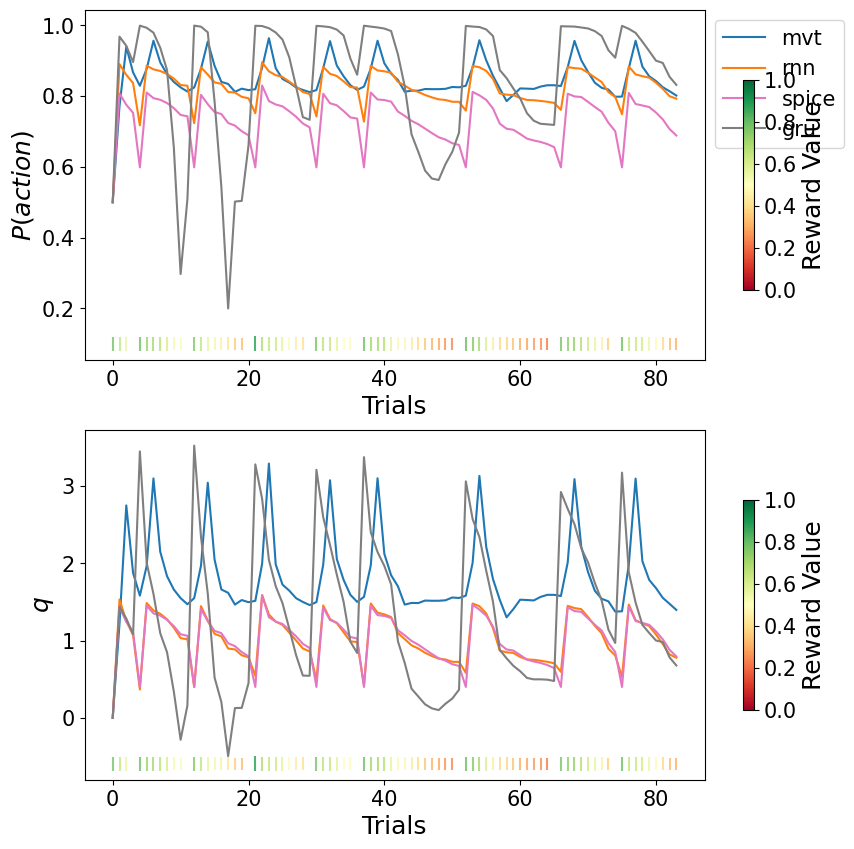

In [16]:
# plotting
participant_id = 7

estimator.print_spice_model(participant_id)

agents = {
    'mvt': mvt_agent,
    'rnn': estimator.rnn_agent,
    'spice': estimator.spice_agent,
    'gru': gru_agent,
}

fig, axs = plot_session(agents, dataset.xs[participant_id], signals_to_plot=[])
plt.show()